# 개요

- 최근 통계학 분야는, 지도학습 방법으로 더 강력한 예측 모델을 만들려고 하고 있다.
- 통계적 머신러닝(statistical machine learning)은, 데이터에 기반하며, 전체적인 구조(선형인지 등)는 가정하지 않는다.
- 예
    - k-근접 이웃 방법 : 비슷한 레코드들 끼리 분류
    - 앙상블 학습을 적용한 의사 결정 트리 : 복수의 약한 학습기(의사결정트리)를 높은 성능을 얻는 방법
- 머신러닝과 통계학의 차이
    - 머신러닝 : 많은 데이터를 효과적으로 처리 하는 알고리즘 개발 중심
    - 통계학 : 확률론과 모델의 구조를 결정하는데 더 많은 관심

In [1]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

LOAN200_CSV = './datasets/loan200.csv'
LOAN3000_CSV = './datasets/loan3000.csv'
LOAN_DATA_CSV = './datasets/loan_data.csv.gz'

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# k-최근접 이웃
- 기본 아이디어
    - 특징들이 가장 유사한 k개의 레코드를 찾는다
    - 분류 : 이 유사한 레코드들 중에 다수가 속하는 클래스로 새로운 레코드의 클래스 결정
    - 회귀 : 가장 유사한 레코드들 평균을 새로운 레코드의 예측 값으로 사용
- 용어 정리
    - 이웃 : neighbor, 예측 변수에서 값들이 유사한 레코드
    - 거리 지표 : distance metric, 각 레코드 사이가 얼마나 떨어져 있는지를 나타내는 단일 값
    - 표준화 : standardization, 평균을 뺀 후 표준편차로 나누는 일 (유의어 : 정규화)
    - z 점수 : z-score, 표준화를 통해 얻은 값
    - k : 최근접 이웃을 계산하는데 사용하는 이웃의 개수
- 특징
    - 가장 간단한 예측/분류 방법
    - 회귀와 달리 모델을 피팅하는 과정이 필요 없다
    - k와, 어떤 척도로 거리를 측정 할 지를 정해 줘야
    - 예측 변수들은 수치형이여 한다.

## 예제 : 대출 연체 예측

In [ ]:
loan200 = pd.read_csv(LOAN200_CSV)
display(loan200.head())
print(loan200.shape)

predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'


newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)

result = pd.DataFrame(knn.predict_proba(newloan), columns=knn.classes_)
display(pd.concat([newloan, result], axis=1))

- payment_inc_ratio : 소득에 대한 대출 상관 비율 (최대 100)
- dti : 소득에 대한 부채(모기지는 제외) 비율 (최대 100)
- payment_inc_ratio가 9.0, dti가 22.5 인 대출에 대한 예측은, 'paid off'

In [ ]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

- 중간에 있는 'X' 표시는 새로운 대출에 대한 예측 결과
- 네모(상환)과 동그라미(연체)는 학습 데이터를 의미
- 가운데 실선으로 그린 원흔 가까운 20개의 점들에 대한 경계
- 가까운 9개의 대출에 대해 연체, 11번의 대출은 상환
- 따라서 상환이 라고 예측

## 거리 지표
- 유사성은 거리 지표를 통해 결정
- 유클리드 거리 : Euclidean distance, 두 백터간의 각 원소간 차이를 제곱한 뒤 그 값의 제곱근을 구한다.
    - $\sqrt{(x_1 - y_1)^2+(x_2 - y_2)^2+\dots+(x_n - y_n)^2}$
    - 계산상 이점이 있다.
    - KNN은 $k \times n(데이터의수)$ 만큼의 쌍대(pairwise)비교가 필요
    - 데이터가 많을 수록 많은 계산, 계산량 중요
- 맨해튼 거리 : Manhattan distance
    - $|x_1 - y_1|+|x_2 - y_2|+\dots+|x_n - y_n|$
    - 도심지에서 직사각형 건문들 사이를 이동할 때, 두 점 사기의 거리 (대각선으로 건물을 통과해서 못감)
- 마할라노비스 거리 : Mahalanobis distance
    - 벡터간 상관관계를 공분산행렬을 통해 구 하여 거리로 사용, 주성분 사이의 유클리드 거리를 의미 (7장 참조)
    - 계산량이 많다는 단점

## 원-핫 인코더
- 범주형 데이터를, 각 범주 별로 별도의 컬럼(더미 변수)을 만들어서, 0 또는 1로 표현
- pandas의 pd.get_dummies 사용
- 다중공선성 문제를 피하기 위해, get_dummies 함수의 drop_first 옵션 사용
- 그러나 선형모델이 아닌, KNN이나 트리 계열의 모델에서는 다중공선성은 문제가 되지 않아 해당 옵션 사용하지 않음

## 표준화(정규화, z점수)

- 모든 변수에서 평균을 빼고 표준편차로 나누어, 변수들을 동일한 스케일로 만드는 것
    - $\frac{x-\bar{x}}{s}$
- 이렇게 변환한 결과를 z점수 라고 한다.
- 평균으로부터 표준편차만큼 얼마나 떨어져 있는 지를 의미
- KNN이나 주성분분석, 클러스터링 등에서는 반드시 데이터를 표준화 해야 한다.

In [ ]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)


predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
display(newloan)

- revol_bal : 달러로 신청할 수 있는 총 회전 신용(리볼빙 신용)
    - 리볼빙 신용 : 할부 신용과 달리 지불 횟수가 고정되어 있지 않은 신용 유형
- revol_util : 이미 사용중인 리볼빙 신용    

In [ ]:
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
display(newloan)
display(X.iloc[nbrs[1][0], :])

- revol_bal의 값이 다른 값들 보다 너무 커서, revol_bal가 유사한 데이터들이 선택 됨
- 달리 말하면, revol_bal 외의 다른 변수들은 역할이 작음

In [ ]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
display(newloan)
display(X.iloc[nbrs[1][0], :])

- 표준화 후, revol_bal의 영향력이 크게 줄어들었음을 알 수 있음
- revol_bal 외의 다른 변수들도 new_load 과 유사 함을 볼 수 있음
- 하지만 항상 표준화가 정답은 아니다.
    - 도메인 지식을 활용하여, 더 중요한 변수가 있다면 표준화를 안할 수도 있음.
    - 예: 대출 데이터에서, 소득 대비 상환 비율 

## k 선택하기

- k의 선택은 KNN의 성능에 주요한 요소 임
- k=1 인 경우, 데이터에 과적합(오버 피팅)
- k가 클수록 결정함수가 부드럽게, 오버 피팅 위협을 낮춤, 
- 너무 큰 k는 과소 적합(오버 스무딩)
- 정해진 규칙은 없음
- 홀드아웃 데이터를 통해 k 에 따른 평가 
- 보통 1~20사이, 동률을 고려해 홀수로 설정

## KNN을 통한 피처 엔지니어링

- 구현이 간단하여 많이 사용되나, 성능은 그렇게 좋지 않다.
- 하지만 다른 모델들과 함께 사용 할 수는 있다.
    - KNN로 분류 결과(클래스에 속할 확률)을 구한다
    - 이 결과는 해당 레코드의 새로운 특징으로 추가 한다.
    - 새롭게 추가된 특성을 포함하여, 데이터를 다른 알고리즘의 예측에 사용
- 새롭게 추가된 데이터는 다중공선성 문제를 일으키지 않는다.
    - 소수의 근접한 데이터들로 부터 얻은 매우 지엽적인 정보 이기 때문
- KNN을 이와 같이 활용 하는 것은, 다양한 모델을 사용하는 앙상블과 유사한 효과
- 예 : 킹 카운티 주택 데이터
    - 주택 가격 산정 시, 최근에 팔린 가격 참조,  일종의 KNN
    - 최근 거래 정보에 KNN을 사용 새로운 특성 생성 (대출자가 대출을 갚지 못할 확률)
    - 예측변수 : 지역, 평수, 구조, 대지면적, 침식 수, 욕실 수

In [ ]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

loan_data['outcome'] = loan_data['outcome'].apply(lambda x : 1 if x == 'default' else 0)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

In [ ]:
X = loan_data[predictors]
y = loan_data[['outcome']]
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
X2 = X.copy()
X2['borrower_score'] = knn.predict_proba(X2)[:, 0]
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in X2['borrower_score']], 
            alpha=0.1, marker='.')
plt.ylabel('borrower_score')
plt.xlabel('index')
plt.show()

- 기본 데이터 결과

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y, test_size=.2)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
f1_score(y_test, y_pred)

- KNN으로 borrower_score 를 추가 한 결과

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=1, stratify=y, test_size=.2)

X_train = pd.DataFrame(X_train, columns=X2.columns)
X_test = pd.DataFrame(X_test, columns=X2.columns)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
f1_score(y_test, y_pred)

# 트리 모델

- 1984년 레오 브라이먼(캘리포티아 대학교 버클리 통계학과 교수)이 개발
    - 회귀 및 분석 트리 (CART, classification and regression tree), 의사 결정 트리(decision tree)
- 이후 강력한 랜덤 포레스트(Random forest)와 부스팅 트리가 파생
- 재귀 분할 : recursive partitioning, 마지막 분할 영역에 해당하는 출력이 최대한 비슷한 결과를 보이도록 데이터를 반복 분할
- 분할값 : split value, 예측 변수가 분할값 보다 작으면 분할
- 마디 : node, 의사 결정 트리 등에서 가지치기 형태로 구성된 규칙들의 집합에서, 분할 규칙의 시각적 표시
- 잎 : leaf, 트리의 맨 마지막 부분, 최종적 분류 규칙
- 손실 : loss, 분류하는 과정에서 발생하는 오분류의 수
- 불순도 : impurity, 데이터를 분할한 집합에서 서로 다른 클래스의 데이터가 얼마나 섞여 있는지
- 가지치기 : pruning, 학습이 끝난 트리의 오버피팅을 줄이기 위해 가지들을 제거 하는 과정

- 특징
    - 트리는 일종의 if-then-else 규칙의 집합체
    - 이해하기 쉽다

## 간단한 예제
- 트리를 그릴 때는, 잎이 아래로 가도록 뒤집어 그린다
- 우분투의 경우, sudo apt-get install graphviz 필요

In [ ]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

## 재귀 분할 알고리즘
- 재귀 분할 : 예측변수 값을 기준으로 데이터르 반복적으로 분할 해 나가는 의사 결정 트리 알고리즘
- 분할할 때에는 상대적으로 같은 클래스의 데이터들 끼리 구분되도록 한다

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

- 응답변수 $Y$와 $P$개의 예측변수 집합 $X_j(j=1, \dots , P)$가 있다고 가정
- 어떤 파티션(분할영역) $A$에 대해, $A$개의 하위 분할 영역으로 나누기 위해 가장 좋은 재귀적 분할 방법 찾기
- 기본 분할 알고리즘
    - 1. 각 예측변수 $X_j$에 대해
        - a. $X_j$에 해당하는 각 변수 $s_j$에 대해
            - i. $A$에 해당하는 모든 레코드를 $X_j< s_j$ 인 부분과 $X_j  \geq s_j$ 인 부분으로 나눈다
            - ii. $A$의 각 하위 분할 영역안에 해당 클래스의 동질성을 측정한다
        - b. 하위 분할 영역 내에서 클래스 동질성이 가장 큰 $s_j$ 값을 선택 한다.
    - 2. 클래스 동질성이 가장 큰 변수 $X_j$와 $s_j$ 값을 선택 한다.
- 재귀 부분
    - 1. 전체 데이터를 가지고 $A$를 초기화
    - 2. $A$를 두 부분, $A_1$과 $A_2$로 나누기 위해 분할 알고리즘 적용
    - 3. $A_1$과 $A_2$ 각각에 대해 2번 과정 반복
    - 4. 분할을 해도 더는 하위 분할 영역의 동질성이 개선되지 않을 정도로 출분히 분할 진행, 알고리즘 종료

## 동질성과 불순도 측정하기
- 트리 모델링은 분할 영역 $A$를 재귀적으로 만드는 과정
- 이렇게 만들어진 분할 영역을 통해 $Y=0$ 혹은 $Y=1$의 결과 예측
- 클래스의 순도(class purity), 즉 분할 영역에 대한 동질성 이나 불순도를 측정하는 방법이 필요
- 불순도 측정 지표로, 지니 불순도(Gini impurity)와 엔트로피(entropy)가 대표적
- 지니 불순도 (이진 분류 가정)
    - $I(A) = p(1-p)$
    - $p$ : $A$에서 1일 확률
- 엔트로피:
    - $I(A) = -plog_2(p) -  (1-p)log_2(1-p)$

In [ ]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

In [ ]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

- 정확도가 0.5인 지점에서, 지니 불순도와 엔트로피가 같이 높아 진다는 것을 알 수 있다.
- [참고자료](https://data-science-hi.tistory.com/59)

## 트리 형성 중지하기
- 트리가 커질 수록, 노이즈 까지 학습하는 오버피팅 상태가 됨
- 좋은 일반화 성능을 위해서는 트리의 성장을 멈추거나, 잘라 내야 한다.
- 언제 트리 성장을 멈춰야 하는가.
    - 분할을 통해 얻어지는 하위 영역 또는 말단 잎의 크기가 너무 작다
        - DicisionTreeClassifier 의 min_samples_split(기본값 2), min_samples_leaf(기본값 1) 
    - 새로운 분할 영역이 '유의미'한 정도로 불순도를 줄이지 않는다면 멈춘다
        - DicisionTreeClassifier의 min_impurity_decrease
    - 트리의 크기 제어
        - max_depth (5~30 사이)

## 연속값 예측하기
- 분류와 기본적으로 동일
- 차이점
    - 불순도 측정 : 각 하위 분할 영역의 평균으로 부터의 편차들의 제곱값을 이용
    - 예측 성능 평가 : RMSE

## 트리 활용하기
- 트리 모델의 장점
    - 데이터 탐색을 위한 시각화 가능
    - 변수간 중요도 표시 가능
    - 예측변수들 간의 비선형 관계 포함 가능
    - 비전문가와의 대화에 알고리즘에 대한 설명을 하기 적합

# 배깅과 랜덤 포레스트

- 앙상블 : ensemble, 여러 모델의 집합을 이용, 하나의 예측을 이끌어내는 방식
- 부트스트래핑 : bootstrapping, 단일 랜덤 표본에서 복원으로 여러 표본을 가져와서 표본 추출 분포를 추정하는 방법
- 배깅 : bagging, 데이터를 부트스트래핑해서 여러 모델을 만드는 일반적 방법
- 랜덤포레스트 : random forest, 의사 결정 트리 모델에 기반한 배깅 추정 모델
- 변수 중요도 : variable importance, 모델 성능에 예측변수의 중요도
- 앙상블의 예
    - 주어진 데이터에 대해 예측 모델을 만들고 예측 결과 기록
    - 같은 데이터에 대해 여러 모델을 만들고 결과를 기록
    - 각 레코드에 대해 예측된 결과들의 평규(또는 가중 평균, 다수결 투표)를 구함

## 배깅

- 배깅(bagging)은 bootstrap aggregation의 준말, 1994년 레오 브레이먼이 처음 발표
- 응답변수 $Y$와 $P$개의 예측변수 집합 $X_j(j=1, \dots , P)$이 $N$개 있다고 가정
- 배깅은 다양한 모델들을 매번 부트스트랩 재표본을 하여 새로운 모델을 만든다
    - 1. 만들 모델의 개수 $M$과 모델을 만드는 데 사용할 레코드의 수 $n(n < N)$의 값을 초기화, $m=1$로 설정
    - 2. 훈련 데이터로부터 복원추출 방법으로 $n$개의 부분 데이터 $Y_m$과 $X_m$을 부트스트랩 재표본 추출
    - 3. 의사결정 규칙 $\hat{f}_m(X)$를 얻기 위해, $Y_m$과 $X_m$을 이용 모델 학습
    - 4. $m = m+1$로 모델 개수를 늘린다, $m \leq M$이면 다시 2단계로 간다.
- $\hat{f}_m$이 $Y=1$ 인 경우의 확률을 예측한다고 했을때, 배깅 추정치는 다음과 같다.
    - $\hat{f} = \frac{1}{M}(\hat{f}_1(X) + \hat{f}_2(X) + \dots + \hat{f}_M(X))$

## 랜덤 포레스트

- 랜덤 포레스트는, 의사 결정 트리 모델에 배깅 적용한 모델
- 레코드 표본 추출시, 변수 역시 샘플링 함
    - 변수 샘플링 기준 : $P$개의 변수가 있을 때, $\sqrt{P}$개
- 즉, 고를 수 있는 변수가 랜덤하게 결정된 전체 변수들의 부분집합에 한정
    - 1. 전체 데이터로 부터 부트스트랩 샘플링(복원추출)
    - 2. 비복원 임의추출로 $p(p<P)$개의 변수 샘플링
    - 3. 샘플링된 변수 $X_{j(1)}, X_{j(2)}, \dots , X_{j(p)}$에 대해 분할 알고리즘 적용
        - a. $X_{j(k)}$의 각 변수 $s_{j(1)}$에 대해
            - i. 파티션 $A$에 있는 레로크들을 $X_{j(k)} < s_{j(k)}$인 하위 영역과 $X_{j(k)} \geq s_{j(k)}$인 하위 영역으로 분할
            - ii. $A$의 각 하위 영역 내부의 클래스의 동질성 측정
        - b. 분할 영역 내부의 클래스 동질성을 최대로 하는 $s_{j(k)}$ 값 선택
    - 4. 분할 영역 내부 클래스 동질성을 최대로 하는 $X_{j(k)}$와 $s_{j(k)}$ 값 선택
    - 5. 다음 분할 진행을 위해, 2단계 부터 반복
    - 6. 트리가 모두 자랄때 까지 위 분할 과정 반복
    - 7. 1단계로 돌아가 또 다른 부트스트랩 표본울 추출, 동일 과정 반복


In [ ]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)

- n_estimators=500 : 500개의 트리 학습
- 예측 변수는 2개, 매 단계마다 둘 중 하나의 변수 랜덤하게 선택
- OOB(out-of-bag)추정 에러 : 트리 모델을 만들때 사용하지 않은 데이터로 구한 오차

In [ ]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

In [ ]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')
plt.show()

- 대출 데이터로 구현한 랜덤 포레스트로의 예측 결과 시각화

In [ ]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

- 랜덤 포레스트는 일종의 '블랙박스'
- 단순 트리보다는 훨씬 강력한 예측 모델 이지만
- 직관적인 해석은 불가능

## 변수 중요도
- 랜덤 포레스트는 피처와 레코드의 개수가 많은 데이터에 대해 예측 모델을 만들 때 강점
- 다수의 예측변수 중 어느 것이 중요한지, 변수들 간의 상관관계를 자동 결정

In [2]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

rf_all_entropy = RandomForestClassifier(n_estimators=500, random_state=1,
                                        criterion='entropy') #gini, log_loss
print(rf_all_entropy.fit(X, y))

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)


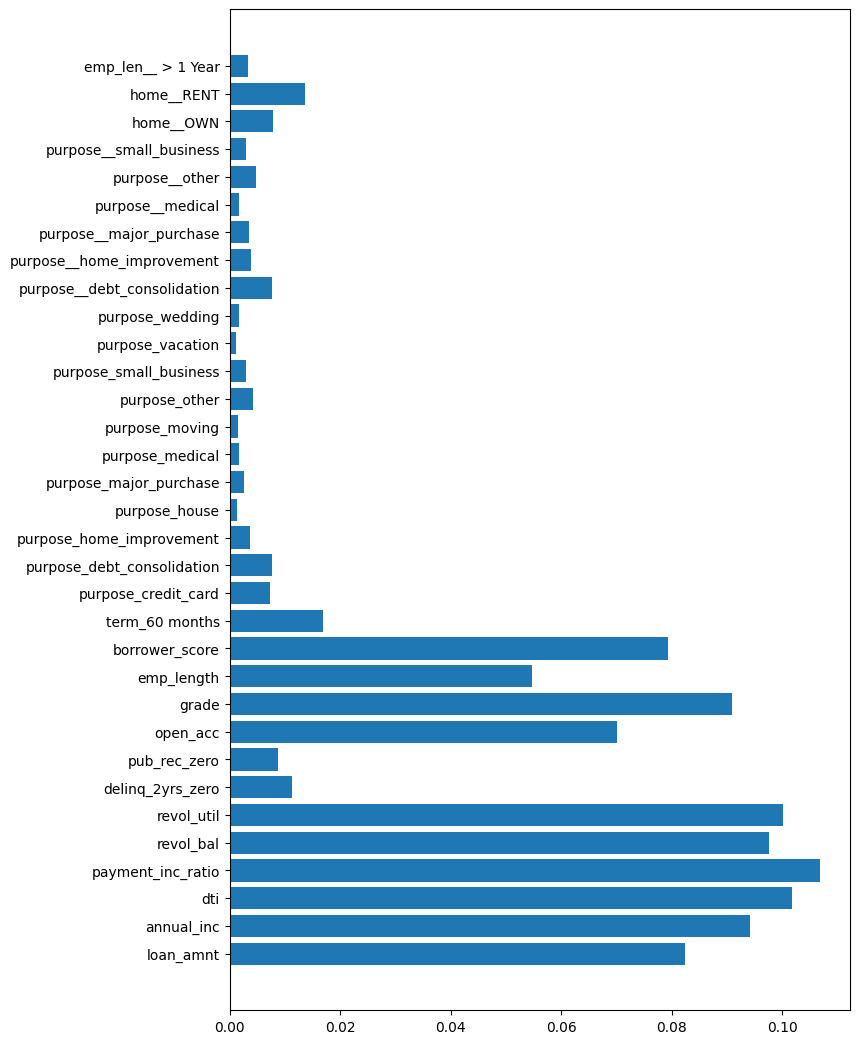

In [9]:
plt.figure(figsize=(8, 13))
plt.barh(X.columns, rf_all_entropy.feature_importances_)
plt.show()

`feature_importances_`는 랜덤 포레스트(Random Forest) 모델에서 각 특성(feature)이 예측 모델에 기여하는 정도를 나타내는 속성(attribute)입니다. `feature_importances_`는 의사결정 트리들이 각각의 특성을 얼마나 중요하게 생각하고 있는지를 나타냅니다.

구체적으로, `feature_importances_`의 값은 다음과 같은 의미를 가집니다:

- 값이 클수록 해당 특성이 예측에 중요하게 작용합니다. 즉, 해당 특성이 예측 모델의 결과에 큰 영향을 미칩니다.
- 값이 작거나 0에 가까울수록 해당 특성이 예측에 미치는 영향이 적거나 없다고 볼 수 있습니다.
- 모든 특성의 `feature_importances_` 값을 합하면 1이 됩니다. 각 특성의 중요도를 나타내는 비율로 해석할 수 있습니다.

## 하이퍼파라미터
- 하이퍼파라미터는 성능을 조절 할 수 있는 일종의 손잡이
- 모델 학습 전에 정해야 함 (학습 과정 중에 최적화 되지 않음)
- 주요 하이퍼파라미터
    - min_samples_leaf : 말단 노드의 크기
    - max_leaf_nodes : 최대 말단 노드의 수 (maxnodes = 2*max_leaf_nodes -1)
- 위 파라미터를 크게 하면, 과대적합 가능성이 커짐
- CV 를 통해 하이퍼파라미터를 조절 해야 함

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

loan_data = pd.read_csv(LOAN_DATA_CSV)

predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = loan_data[outcome]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# 랜덤 포레스트 모델 객체 생성
rf_classifier = RandomForestClassifier(random_state=42)

# 튜닝할 하이퍼파라미터 그리드 설정
param_grid = {
    'min_samples_leaf': [1, 2, 4, 8],
    'max_leaf_nodes': [None, 10, 20, 30, 40]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)

# 데이터와 레이블을 사용하여 그리드 서치 수행
grid_search.fit(X_train, y_train)  # X_train과 y_train은 데이터와 레이블에 해당하는 변수입니다.

# 최적의 하이퍼파라미터 조합 출력
print("최적의 하이퍼파라미터 조합:", grid_search.best_params_)

# 최적의 모델 출력
best_rf_model = grid_search.best_estimator_
print("최적의 모델:", best_rf_model)

# 최적의 모델로 예측 수행
y_pred = best_rf_model.predict(X_test)  # X_test는 테스트 데이터에 해당하는 변수입니다.

# 예측 결과 평가
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)  # y_test는 테스트 레이블에 해당하는 변수입니다.
print("정확도:", accuracy)

최적의 하이퍼파라미터 조합: {'max_leaf_nodes': None, 'min_samples_leaf': 8}
최적의 모델: RandomForestClassifier(min_samples_leaf=8, random_state=42)
정확도: 0.6686514499944867


# 부스팅
- 부스팅 : 연속된 라운드마다 잔차가 큰 레코드들에 가장치를 높에 일련의 모델들을 생성하는 방법
- 에이다부스트 : AdaBoost, 잔차에 따라 데이터의 가중치를 조절하는 부스팅 초기 모델
- 그레디언트 부스팅 : Gradient Boosting, 비용함수를 최소화 하는 방향으로 부스팅
- 확률적 그레디언트 부스팅, Stochastic Gradient Boosting, 각 라운드마다 레코드의 열을 재표본추출

## 부스팅 알고리즘

### 에이다부스트(AdaBoost)
에이다부스트(AdaBoost) 알고리즘은 앙상블 학습 방법 중 하나로, 약한 학습자(weak learner)를 결합하여 강력한 학습자(strong learner)를 만드는 기법입니다. 이 알고리즘은 다음과 같이 직관적으로 설명할 수 있습니다.

1. **약한 학습자들을 모아 강한 학습자로**:
   - 에이다부스트는 여러 개의 약한 학습자(성능이 약간 떨어지는 모델)를 모아 하나의 강한 학습자(성능이 높은 모델)를 만드는 것을 목표로 합니다.

2. **어려운 문제에 초점**:
   - 에이다부스트는 이전 학습자들이 풀기 어려운 문제에 더욱 집중합니다. 즉, 이전 학습자들이 틀린 예측을 더 잘 맞추도록 합니다.

3. **가중치를 활용한 학습**:
   - 학습 데이터의 각 샘플(데이터 포인트)에 가중치를 부여합니다. 처음에는 모든 샘플의 가중치가 동일합니다.

4. **모델 학습과 가중치 업데이트**:
   - 첫 번째 약한 학습자를 학습합니다. 이 모델은 일부 샘플을 잘못 예측할 수 있습니다.
   - 잘못 예측된 샘플들의 가중치를 높이고, 올바르게 예측된 샘플들의 가중치를 낮춥니다. 이렇게 하면 다음 약한 학습자는 이전에 어려웠던 샘플에 좀 더 집중할 수 있게 됩니다.

5. **약한 학습자 결합**:
   - 이전 학습자들 중에서 어려운 문제에 더 잘 맞춘 약한 학습자들을 강한 학습자로 결합합니다. 이때, 각 약한 학습자의 예측에 가중치를 부여하여 최종 예측을 만듭니다.

6. **반복**:
   - 위 과정을 반복합니다. 새로운 약한 학습자를 추가하고, 이전 학습자들이 어려웠던 문제에 초점을 맞춰 학습합니다.

7. **최종 강한 학습자**:
   - 일정한 횟수나 성능이 달성될 때까지 반복한 후, 최종 강한 학습자를 얻습니다. 이것이 에이다부스트로 생성된 강력한 모델입니다.

에이다부스트의 핵심 아이디어는 이전 학습자들이 어려운 문제에 더 집중하도록 가중치를 조절하고, 그 결과로 모델의 성능을 향상시키는 것입니다. 이를 통해 약한 학습자들을 결합하여 강력한 예측 모델을 구축할 수 있습니다.

- 에이다부스트 알고리즘
    - 1. 피팅할 모델의 개수 $M$ 설정, $m=1$로 초기화, 관측 가중치 $w_i = 1/N$으로 초기화 $(i=1, 2, \dots , N)$, 앙상블 모델 $\hat{F}_0 = 0$ 으로 초기화
    - 2. 관측 가중치 $w_1, w_2, \dots, w_N$을 이용, 모델 $\hat{f}_m$ 학습, 잘못 분류된 관측치에 대해 가중치를 적용한 합을 의미하는 가중 오차 $e_m$이 최소화 되도록 학습
    - 3. 앙상블 모델에 다음 모델 추가 $\hat{F}_m = \hat{F}_{m-1} + \alpha_{m}\hat{f}_m$, 여기서 $\alpha_{m} = \frac{log1-e_m}{e_m}$
    - 4. 가중치($w_1, w_2, \dots, w_N$)를 잘못 분류된 입력 데이터에 대해 가중치가 증가하는 방향으로 업데이트, $\alpha_{m}$가 증가 폭 결정
    - 5. 모델 반복 횟수 $m = m+1$로 증가, $m \leq M$ 이면 다시 2 단계로 

### 그레디언트 부스팅(Gradient Boosting)
그레디언트 부스팅(Gradient Boosting)과 에이다부스트(AdaBoost)는 둘 다 앙상블 학습 방법이지만, 몇 가지 중요한 차이점이 있습니다.

1. **오차 처리 방식**:
   - 에이다부스트: 에이다부스트는 이전 모델이 틀린 예측한 샘플에 높은 가중치를 부여하여 잘못된 예측을 개선하려고 합니다. 즉, 잘못 분류된 데이터에 집중합니다.
   - 그레디언트 부스팅: 그레디언트 부스팅은 이전 모델의 잔차(residuals)를 줄이는 방향으로 모델을 학습시킵니다. 각 모델은 이전 모델의 오차를 보완하는 방향으로 학습됩니다.

2. **가중치 업데이트**:
   - 에이다부스트: 에이다부스트는 잘못 분류된 데이터 포인트에 가중치를 부여하고, 정확하게 분류된 데이터 포인트의 가중치를 줄이는 방식으로 가중치를 업데이트합니다.
   - 그레디언트 부스팅: 그레디언트 부스팅은 이전 모델의 잔차(오차)에 따라 가중치를 조절하여 모델을 업데이트합니다. 이를 통해 이전 모델이 어떤 데이터를 더 잘 예측하지 못했는지 고려합니다.

3. **알파(Alpha) 또는 학습률(learning rate)**:
   - 에이다부스트는 각 모델의 예측에 동일한 알파 값을 적용합니다. 알파는 모델의 중요도를 조절하는 요소로 사용됩니다.
   - 그레디언트 부스팅은 학습률(learning rate)이라는 하이퍼파라미터를 사용하여 각 모델의 기여를 조절합니다. 학습률은 이전 모델의 기여를 얼마나 크게 반영할지 결정합니다.

요약하면, 에이다부스트와 그레디언트 부스팅은 앙상블 학습 기법으로서 공통점이 있지만, 기본 학습 알고리즘, 오차 처리 방식, 가중치 업데이트, 알파 또는 학습률 등 여러 측면에서 차이가 있습니다. 선택해야 하는 경우에는 문제의 특성과 데이터에 맞는 알고리즘을 선택해야 합니다.

- 오차와 잔차
    - "오차" : 모집단에서 회귀식을 얻었다면, 그 회귀식을 통해 얻은 예측값과 실제 관측값의 차이
    - "잔차" : 표본집단에서 회귀식을 얻었다면, 그 회귀식을 통해 얻은 예측값과 실제 관측값의 차이

## XGBoost

XGBoost는 "Extreme Gradient Boosting"의 약자로, 그레디언트 부스팅 알고리즘의 하나입니다. XGBoost는 머신 러닝에서 높은 성능과 예측 정확도를 제공하는 강력한 앙상블 학습 알고리즘 중 하나로 널리 사용됩니다. 아래에서는 XGBoost의 주요 특징과 작동 방식을 설명합니다.

**1. 그레디언트 부스팅 알고리즘:**
   - XGBoost는 그레디언트 부스팅 알고리즘을 기반으로 합니다. 그레디언트 부스팅은 여러 개의 약한 학습자(weak learner)를 결합하여 강력한 학습자(strong learner)를 만드는 방법입니다.

**2. 가중치 기반 오차(잔차) 보정:**
   - XGBoost는 이전 모델들의 예측 오차에 가중치를 부여하고, 다음 모델을 학습할 때 이 오차를 줄이는 방향으로 학습합니다. 이를 통해 이전 모델이 잘못 예측한 샘플에 더욱 집중할 수 있습니다.

**3. 트리 알고리즘 활용:**
   - XGBoost는 의사결정 트리(Decision Trees)를 기본 학습 알고리즘으로 사용합니다. 각 트리 모델은 이전 트리 모델의 오차를 보정하는 방향으로 학습됩니다.

**4. 정규화와 복잡성 제어:**
   - XGBoost는 트리 모델의 복잡성을 제어하기 위해 L1(Lasso) 및 L2(Ridge) 정규화를 사용합니다. 이를 통해 모델이 과적합되지 않도록 하고 예측 성능을 향상시킵니다.

**5. 자동적인 가지치기:**
   - XGBoost는 가지치기(Pruning) 기술을 사용하여 불필요한 분기를 제거하고 모델을 간소화합니다. 이는 모델의 일반화 능력을 향상시키는 데 도움을 줍니다.

**6. 다양한 손실 함수 지원:**
   - XGBoost는 분류와 회귀 문제에 모두 적용 가능하며, 다양한 손실 함수(loss function)을 지원합니다. 예를 들어, 로지스틱 손실 함수를 사용하여 이진 분류 문제를 다룰 수 있습니다.

**7. 병렬 처리와 고속화:**
   - XGBoost는 병렬 처리를 통해 대용량 데이터셋에서도 빠르게 학습할 수 있는 기능을 제공합니다. 또한 고도로 최적화되어 있어 속도와 효율성 면에서 우수합니다.

XGBoost는 대회에서 좋은 성적을 기록하거나, 실제 산업 응용에서 예측 모델을 개발할 때 널리 사용되는 머신 러닝 라이브러리 중 하나입니다. 그레디언트 부스팅의 강력한 성능과 다양한 기능을 활용하여 데이터 과학 및 머신 러닝 프로젝트를 수행하는 데 도움이 됩니다.

- 주요 하이퍼파라미터
    - subsample : 각 반복 구간마다 샘플링할 입력 데이터의 비율, 비복원추출
    - eta : 부스팅 알고리즘에서, $\alpha_m$에 적용되는 축소 비율, eta로 가중치의 변화량을 낮추어 오버피팅 방지 효과

In [12]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63, 
                    use_label_encoder=False, eval_metric='error')
print(xgb.fit(X, y))

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [13]:
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.828856
1            0.40            5.43165    default      0.260156
2            0.70            9.23003    default      0.320805
3            0.40            2.33482   paid off      0.678005
4            0.45           12.10320    default      0.140204


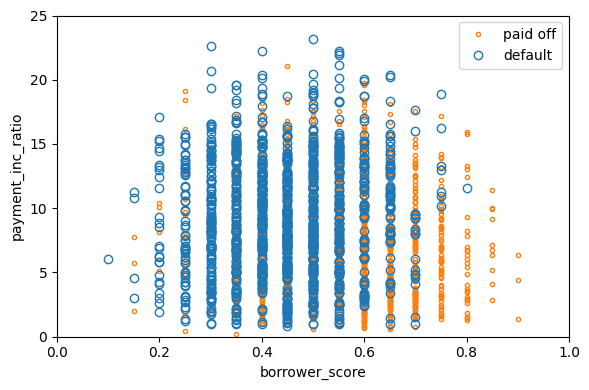

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

## 정규화 : 오버피팅 피하기

- 오버피팅의 문제점
    - 학습 데이터에 없는 새로운 데이터에 대한 모델 정확도가 떨어진다
    - 모델 예측 결과에 변동성이 커지고, 불안정한 결과가 나온다

In [15]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1,
                            use_label_encoder=False, eval_metric='error')
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            use_label_encoder=False, eval_metric='error')
print(xgb_penalty.fit(train_X, train_y))

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


과적합(Overfitting)을 막기 위한 정규화 방법은 머신 러닝 및 딥 러닝 모델에서 중요한 기술 중 하나입니다. 아래에는 주요한 정규화 방법들을 설명합니다.

1. **L1 정규화 (Lasso 정규화)**:
   - L1 정규화는 모델의 가중치(계수)에 대한 절대값을 패널티로 부여하여 일부 가중치를 0으로 만듭니다. 이는 모델에 불필요한 특성(feature)을 제거하고 모델을 더 간단하게 만드는 데 도움을 줍니다.
   - L1 정규화는 특히 특성 선택(feature selection)에 유용합니다.
   - reg_alpha 로 적용

2. **L2 정규화 (Ridge 정규화)**:
   - L2 정규화는 모델의 가중치(계수)에 대한 제곱을 패널티로 부여하여 가중치를 줄이지만 0으로 만들지는 않습니다. 이는 모델의 가중치를 조절하여 과적합을 방지하고 모델의 일반화 성능을 향상시킵니다.
   - L2 정규화는 가중치 간의 상호 작용을 줄이는 효과가 있습니다.
   - reg_lambda 로 적용

3. **엘라스틱 넷 정규화 (Elastic Net 정규화)**:
   - 엘라스틱 넷 정규화는 L1 정규화와 L2 정규화를 결합한 방법으로, 두 가지 정규화 패널티를 동시에 적용합니다. 이는 두 정규화 방법의 장점을 모두 활용하고자 할 때 사용됩니다.
   
<img src="./figs/ch6_1.png">

In [16]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.12608228170448757
default:  0.3511
penalty:  0.3251


In [17]:
results = []
for ntree_limit in range(1, 250):
    iteration_range = [1, ntree_limit + 1]
    train_default = xgb_default.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

   iterations  default train  penalty train  default test  penalty test
0           1       0.345255       0.334220        0.3588        0.3455
1           2       0.330428       0.336710        0.3415        0.3433
2           3       0.326099       0.336880        0.3405        0.3450
3           4       0.322647       0.338492        0.3407        0.3452
4           5       0.319478       0.336455        0.3382        0.3424


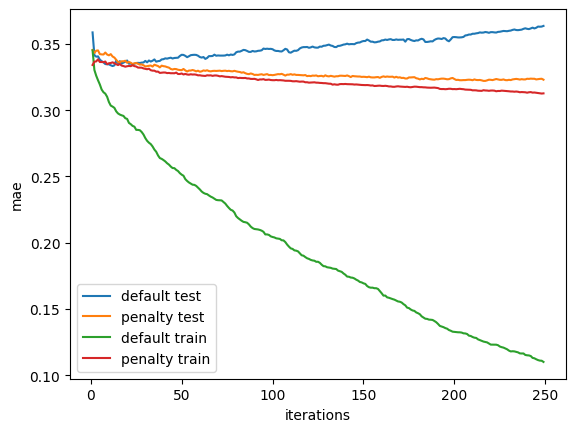

In [21]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.ylabel('mae')
plt.show()

- default는 학습의 오차 보다 테스트 시의 오차가 큼, 과적합
- penalty는 학습과 테스트의 오차가 비슷

## 하이퍼파라미터와 교차타당성 검사

### XGBoost의 하이퍼파라미터
- learning_rate : 부스팅 알고리즘에서 $\alpha$에 해당
- n_estimators : 부스팅 라운드 횟수
- max_depth : 트리의 최대 깊이 (기본 6)
- colsample_bytree : 전체 데이터에 일부 데이터를 비복원 샘플링하는 비율
- reg_lambda, reg_alpha : 정규화를 위해 사용 (앞에 설명)

In [22]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# 튜닝할 하이퍼파라미터 그리드 설정
param_grid = {
    'eta': [0.1, 0.5, 0.9],
    'max_depth': [3, 6, 9]
}

# XGBoost 모델 객체 생성
xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, eval_metric='error')

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)

# 데이터에 맞게 X, y를 설정해야 합니다.
# train_X, train_y, valid_X, valid_y를 구분하여 데이터를 나눠야 합니다.
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

# 데이터 분할 및 그리드 서치 수행
grid_search.fit(train_X, train_y)

# 최적의 하이퍼파라미터 조합 출력
print("최적의 하이퍼파라미터 조합:", grid_search.best_params_)

# 최적의 모델 출력
best_xgb_model = grid_search.best_estimator_
print("최적의 모델:", best_xgb_model)

# 최적의 모델로 예측 수행
pred = best_xgb_model.predict_proba(valid_X)[:, 1]

# 평가 및 결과 출력
cv_error = np.mean(abs(valid_y - pred) > 0.5)
print("Validation Error:", cv_error)

최적의 하이퍼파라미터 조합: {'eta': 0.1, 'max_depth': 3}
최적의 모델: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='error',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)
Validation Error: 0.3247
